# 4 - Network Simulation II

In this tutorial I show how we can combine several simulation iterations in order to find out what would have been the most likely paths.

### imports

In [2]:
import netsim.generate as ng
import netsim.utils as utils
import netsim.path_tools as ptools
import netsim.simulate as ns
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio as ro
from pathlib import Path

### Set data path

In [3]:
data_path = Path.cwd().parent / "data"

### Reading files

#### *Read DEM*

In [2]:
fn_dem = data_path / "sample" / "sampleDEM.tif"

In [3]:
dem, profile = utils.read_raster(fn_dem)

In [4]:
#find the cellsize of the dem
cellsize = profile['transform'].a

#### *Read shapefile into a geopandas dataframe*

In [5]:
fn_shp = data_path / "sample" / "sample5.shp"

##### read and make a copy of original dataframe

In [6]:
df_temp = gpd.read_file(fn_shp)

# make a copy
df = df_temp.copy(deep=True)
df

,id,seq,group,mix,easting,northing,geometry
0,0,1,1,0,530782,4389390,POINT (530782 4389390)
1,1,1,1,0,531119,4388860,POINT (531119 4388860)
2,2,1,1,0,530403,4388580,POINT (530403 4388580)
3,3,1,1,0,530503,4388620,POINT (530503 4388620)
4,4,1,1,0,530729,4388930,POINT (530729 4388930)
5,5,1,1,0,530606,4389150,POINT (530606 4389150)


### Preliminaries

#### *Convert point coordinates into rows and column and add to dataframe*

In [7]:
df['r'], df['c'] = utils.pt2rc(df['geometry'], profile)
df

,id,seq,group,mix,easting,northing,geometry,r,c
0,0,1,1,0,530782,4389390,POINT (530782 4389390),18,104
1,1,1,1,0,531119,4388860,POINT (531119 4388860),124,171
2,2,1,1,0,530403,4388580,POINT (530403 4388580),180,28
3,3,1,1,0,530503,4388620,POINT (530503 4388620),172,48
4,4,1,1,0,530729,4388930,POINT (530729 4388930),110,93
5,5,1,1,0,530606,4389150,POINT (530606 4389150),66,68


In [8]:
# check values
df = ng.check(df)


 No corrections or errors !! 


#### *Plot locations*

In [9]:
hillshade = utils.calculate_hillshade(dem)

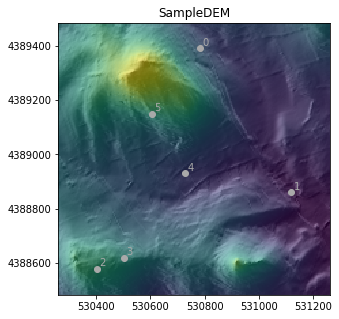

In [10]:
utils.plot_map(raster = {'ras':dem, 'profile':profile, 'bground': hillshade},
               loc= {'df':df, 'label': 'id'},
               title='SampleDEM')

### create network generator

In [11]:
# create network generator
netgentor, net_info, total_iterations = ng.create_network_generator(df)


 iteration broken per group....

   group  num_loc  num_iter iter_type
0      1        6       100    sample

 total number of iterations.... 100


### Setup Simulation

##### *find coefficients for gradient to cost function*

In [12]:
# vertical factor table
vftfn = data_path / "iwdt" / "grad2cost.csv"

# read file slope (tan) to cost
vft = np.genfromtxt(vftfn, delimiter=',')

In [13]:
# fit values to 4th degree polynomial and return coefficients
coef = np.polyfit(np.tan(np.radians(vft[: , 0])), vft[:,1], deg=4)
coef

array([ 14.58472386, -20.89105302,  41.30992529,  16.89952776,
         2.57058679])

##### Set up cost dictionary

In [14]:
cost_dict={
    'dem': dem,
    'netcost': np.zeros_like(dem),
    'cellsize': cellsize,
    'weight': 0.5,
    'coef': coef
}

##### *calculate decay factor $\alpha$ for given $d_0$ and $NC_0$*

We shall specify that at a distance of $d_0$=10m the network cost (i.e. the effect of the existing network) will decrease to $\frac{1}{2} $.  

In [15]:
from math import log

d0 = 10 # distance @ which 
NC0 = 0.5  # cost reduces to 50%
alpha = d0 / log(1- NC0)

##### Set up netsim dictionary

In [16]:
netsim_dict= {
    'i': 1.0,      # path impact
    'Gmax': 5.0,   # path saturation
    'T': 10,       # residuality 
    'alpha': alpha # decay factor 
    }

### Run *nsim* simulations

In [17]:
progress = lambda i, n=10: print ('Processing: '+str(i//n), end = "") if i % n == 0 else print('.', end = "")

In [18]:
# number of iterations 
nsim = 5

##### initialize variables

In [19]:
all_path_lst = []
all_paths = np.zeros_like(dem)#, dtype=np.float64)
prev_id = 0
save_flag = False # Change to True if you want to save the result as an image
save_fn =  Path.cwd() / 'all_paths'

##### run simulations

In [20]:
for isim in range(nsim):
    
    # progress
    progress(isim)
    
    # generate network iteration
    net_iteration = list(next(netgentor))
    
    # create path network layout for current iteration
    df_net = ng.network_layout(df, net_iteration, isim, opt='decentral')
    
    # simulate network
    _, paths, path_lst = ns.simulation(df, df_net, cost_dict, netsim_dict)
    
    # add current iteration path list to that of previous iterations 
    for pth in path_lst:
        pth['id'] += len(all_path_lst)
    all_path_lst += path_lst
    
    # generate dataframe output
    df_paths = pd.DataFrame(all_path_lst, columns=['id', 'origin','destination', 'track'])
    
    # add current path network to path networks from previous iterations
    all_paths += paths
    
    if save_flag:
        df_paths.to_pickle(save_fn)
        with ro.open( save_fn+'.tif', 'w', **profile) as ras:
            ras.write(all_paths, 1)

Processing: 0....

#### number of paths generated?

In [21]:
len(df_paths)

75

#### Plot the sum of all simulations i.e. 'all_paths'

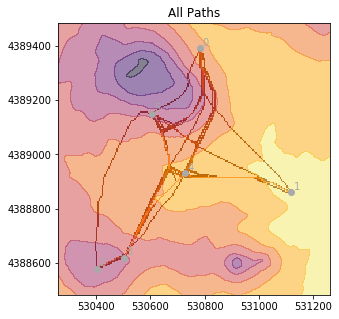

In [22]:
utils.plot_map(raster = {'ras':dem, 'profile':profile, 'paths': all_paths},
               loc= {'df' : df, 'label': 'id'},
               title= 'All Paths',
               cmap= 'inferno_r')

#### Show the tracks of all paths generated

In [23]:
df_paths

,id,origin,destination,track
0,1,"[180, 28]","[66, 68]","[[66, 66, 66, 65, 65, 65, 65, 65, 65, 66, 67, ..."
1,2,"[180, 28]","[172, 48]","[[172, 172, 172, 173, 173, 174, 174, 175, 175,..."
2,3,"[180, 28]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ..."
3,4,"[180, 28]","[110, 93]","[[110, 110, 110, 109, 109, 108, 108, 107, 107,..."
4,5,"[180, 28]","[124, 171]","[[124, 124, 123, 123, 122, 122, 121, 121, 120,..."
5,6,"[66, 68]","[172, 48]","[[172, 171, 170, 169, 168, 167, 166, 165, 164,..."
6,7,"[66, 68]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ..."
7,8,"[66, 68]","[110, 93]","[[110, 110, 110, 109, 109, 108, 108, 107, 107,..."
8,9,"[66, 68]","[124, 171]","[[124, 124, 123, 123, 122, 122, 121, 121, 120,..."
9,10,"[172, 48]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ..."


#### For each path, sum values extracted from the 'all_paths'

In [24]:
# the default in paths_stats() is the sum() function 
df_paths = ptools.path_stats(df_paths, all_paths, df)

#### For each pairing, select those paths that maximize the `sum()`

Out of each of the five paths that have been generated for each pairing, we want the one for which the sum along its track of the values found in 'all_path' is the largest. This path would correspond to a path that goes along a well trodden area.

In [25]:
df_max_paths = df_paths.loc[df_paths.groupby(['path_ids'])['sum'].idxmax()]
df_max_paths

,id,path_ids,origin,destination,track,sum
25,26,"(0, 1)","[18, 104]","[124, 171]","[[124, 124, 123, 123, 122, 122, 121, 121, 120,...",2925.0
30,31,"(0, 2)","[18, 104]","[180, 28]","[[180, 180, 180, 179, 179, 178, 178, 178, 177,...",2143.0
24,25,"(0, 3)","[18, 104]","[172, 48]","[[172, 171, 170, 169, 168, 167, 166, 165, 164,...",2201.0
26,27,"(0, 4)","[18, 104]","[110, 93]","[[110, 111, 111, 112, 112, 111, 111, 110, 110,...",1366.0
34,35,"(0, 5)","[18, 104]","[66, 68]","[[66, 66, 67, 67, 68, 68, 69, 69, 70, 70, 71, ...",766.0
57,58,"(1, 0)","[124, 171]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ...",1839.0
42,43,"(1, 3)","[124, 171]","[172, 48]","[[172, 171, 170, 169, 168, 167, 166, 165, 164,...",2882.0
29,30,"(1, 4)","[124, 171]","[110, 93]","[[110, 111, 111, 112, 112, 113, 113, 113, 113,...",1488.0
43,44,"(1, 5)","[124, 171]","[66, 68]","[[66, 66, 67, 67, 68, 69, 70, 71, 72, 73, 74, ...",2072.0
16,17,"(2, 0)","[180, 28]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ...",2251.0


### Plot results

Instead of plotting all paths generated from all the simulations, we are plotting those that for each pairing, maximize the sum of the values found along each track.

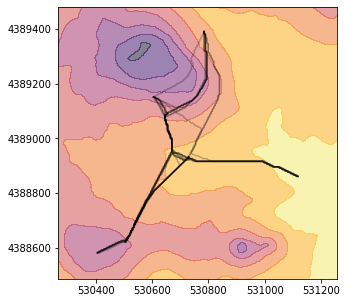

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# calculate extension
bounds = profile['bounds']
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# plot image
cmap = mpl.cm.get_cmap('inferno_r')
fig, ax = plt.subplots(ncols= 1, figsize= (5,5))
im = ax.contourf(dem, 6, extent=extent, origin= 'upper', cmap= cmap, alpha=0.5)
for i, path in df_max_paths.iterrows():

    X = [pt[0] for pt in utils.rc2pt(path['track'], profile)]
    Y = [pt[1] for pt in utils.rc2pt(path['track'], profile)]
    ax.plot (X, Y, 'k-', alpha= 0.25)
